In [ ]:
! pip install transformers sentence-transformers langchain langchain_community torch faiss-cpu numpy pypdf accelerate bitsandbytes rank_bm25 langchain_openai langgraph openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 12.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# from urllib.request import urlretrieve
import numpy as np
from langchain_community.embeddings import HuggingFaceBgeEmbeddings, HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.document_loaders import CSVLoader
from langchain_community.document_transformers import LongContextReorder
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate



In [ ]:
import re
import copy
import json
import pickle
import pandas as pd

In [ ]:
#OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import OpenAIEmbeddings
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.tools import tool
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser


In [ ]:
loader = CSVLoader(file_path='/content/drive/MyDrive/B-DATA/Analyses_Dataset.csv', csv_args={
    'delimiter': ';'},source_column="Model")

data = loader.load()

In [ ]:
for doc in data:
  # lowercase
  doc.page_content = doc.page_content.lower()

  # remove unneccesssary elements
  doc.page_content = re.sub(r'\ufeffanswer:\s*', '', doc.page_content)
  doc.page_content = re.sub(r'\nmodel: llama 3 8b\s*', '', doc.page_content)
  doc.page_content = re.sub(r'\nmodel: gpt-3.5-turbo\s*', '', doc.page_content)

  del doc.metadata['row']

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap  = 100,
)

In [ ]:
# Split documents into chunks
chunks = text_splitter.split_documents(data)

In [ ]:
# ## post process the introduced _lc_kwargs= attr
# for chunk in chunks:
#     if hasattr(chunk, '_lc_kwargs'):
#         delattr(chunk, '_lc_kwargs')

In [ ]:
avg_doc_length = lambda docs: sum([len(doc.page_content) for doc in docs])//len(docs)
avg_words = lambda docs: sum([len(doc.page_content.split()) for doc in docs])//len(docs)

In [ ]:
min_words = lambda docs: min([len(doc.page_content.split()) for doc in docs])
max_words = lambda docs: max([len(doc.page_content.split()) for doc in docs])

In [ ]:
# avg_char_before_split = avg_doc_length(docs_processed)
avg_char_after_split = avg_doc_length(chunks)

In [ ]:
max_words_chunks = max_words(chunks)

In [ ]:
print(max_words_chunks)

249


In [ ]:
total_words = lambda docs: sum([len(doc.page_content.split()) for doc in docs])


In [ ]:
print(total_words(chunks))

823646


In [ ]:
# print(f'Pre-split: {len(docs_processed)} documents loaded, with average characters equal to {avg_char_before_split}.')
print(f'Post-split: {len(chunks)} documents (chunks), with average characters equal to {avg_char_after_split}.')

Post-split: 5117 documents (chunks), with average characters equal to 1078.


In [ ]:
# avg_word_before_split = avg_words(docs_processed)
avg_words_after_split = avg_words(chunks)

In [ ]:
# print(f'Pre-split: {len(docs_processed)} documents loaded, with average words equal to {avg_word_before_split}.')
print(f'Post-split: {len(chunks)} documents (chunks), with average words equal to {avg_words_after_split}.')

Post-split: 5117 documents (chunks), with average words equal to 160.


In [ ]:
# save chunks to pkl
with open('/content/drive/MyDrive/chunks_Analysis.pkl', 'wb') as f:
    pickle.dump(chunks, f)

## Embeddings for RAG
To create RAG we need the documents to be embedded and stored in a vector store type of database. The retriever can fetch the relevant documents based on embedding similariy between query and documents

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name ='intfloat/multilingual-e5-large')


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [ ]:
test_embedding = np.array(embeddings.embed_query(chunks[1].page_content))


In [ ]:
print(test_embedding)

[ 0.02394896 -0.02155611 -0.01319544 ... -0.02653489 -0.05505569
 -0.01338697]


In [ ]:
test_embedding.shape # should be 1024

(1024,)

### vector store

In [ ]:
# def create_faiss(chunks=chunks):

#   path = f"/content/drive/MyDrive/B-DATA/faiss_store_Analysis"

#   # create vectore store only for those chunks belong to specific ecli
#   vector_store = FAISS.from_documents(chunks, embeddings)

#   # save vector store for ecli
#   vector_store.save_local(path)



In [ ]:
# create_faiss()

In [ ]:
def load_faiss(embeddings=embeddings):
  """
  Loads vector store for each ecli

  """
  path = f"/content/drive/MyDrive/B-DATA/faiss_store_Analysis"


  try:
      vector_store = FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)
      print(f"Loaded FAISS store")
      return vector_store

  except Exception as e:
      print(f"Failed to load FAISS store: {str(e)}")
      return None



In [ ]:
# vector_store_test = load_faiss(embeddings=embeddings)

Loaded FAISS store


## Retriever
Using FAISS for optimized similarity search between query and embeddings

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever



In [ ]:
def initialize_retriever(top_n_keywords, top_n_sim, chunks,
                         w_vectors, w_keywords,
                         vector_store):

  vector_retriever = vector_store.as_retriever(search_kwargs={"k": top_n_sim})
  keyword_retriever = BM25Retriever.from_documents(chunks)
  keyword_retriever.k =  top_n_keywords

  ensemble_retriever = EnsembleRetriever(retrievers=[vector_retriever,
                                                   keyword_retriever],
                                       weights=[w_vectors, w_keywords])

  return ensemble_retriever


In [ ]:
#  ensemble_retriever_t = initialize_retriever(top_n_keywords=25, top_n_sim=25, chunks=chunks,
#                       w_vectors = 0.4, w_keywords=0.6, vector_store=vector_store_test)

## Reranker

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

In [ ]:
reranker = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3") # cross-encoder model

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
def init_ranked_retriever(ensemble_retriever,
                          reranker):
  compressor = CrossEncoderReranker(model=reranker, top_n=30)
  compression_retriever = ContextualCompressionRetriever(
      base_compressor=compressor, base_retriever=ensemble_retriever)

  return compression_retriever

### Response Model HUGGINGFACE

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig

In [ ]:
# initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    model_name: Name or path of the model for tokenizer initialization.
    return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

In [ ]:
# function for loading 4-bit quantized model
def quantized_model(model_name: str):
    """
    model_name: Name or path of the model to be loaded.
    return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map='auto',
        quantization_config=bnb_config,
    )
    return model

In [ ]:
# from huggingface_hub import login
# login()

In [ ]:
# model_id = 'ReBatch/Llama-3-8B-dutch'

In [ ]:
# model_id_multi = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [ ]:
# tokenizer = initialize_tokenizer(model_id)

In [ ]:
# model = quantized_model(model_id)

In [ ]:
# pipe = pipeline(
#  model=model,
#  tokenizer=tokenizer,
#  task="text-generation",
#  temperature=0.0,
#  repetition_penalty=1.1,
#  return_full_text=True,
#  max_new_tokens=500,
# )

In [ ]:
# llm = HuggingFacePipeline(pipeline=pipe)

In [ ]:
# # prompt to instruct llm agent for answering on the analysis data base

# """3) Identificeer uit de deze elementen en fragmenten of het gaat over een van deze 3 discussie punten:
# -3.1) Het interstatelijke vertrouwenbeginsel (in dit geval: als de Franse rechter zegt dat de gegevens op een correcte manier verkregen zijn, kan dat in Nederland worden overgenomen)
# -3.2) Nederlandse strafrechtautoriteiten beweren wel dat die PGP-telefoons alleen door criminelen gebruikt worden
# -3.3) De verdediging van advocaten heeft niet op dezelfde manier toegang tot cryptodata als de strafrechtautoriteiten

# 4) Indien een of meerdere discussie punten gevonden, neem dan de volgende bezwaren in acht:
# -4.1) Het interstatelijke vertrouwenbeginsel. Bezwaar: geldt niet altijd en niet per se (zeker niet omdat de Nederlandse politie kennelijk betrokken was bij het toegang verkrijgen tot – niet: hacken van - de Encrochat-data).
# -4.2) PGP-telefoons wordem alleen door criminelen gebruikt. Bezwaar: Dat is niet het geval. Straks kunnen langs deze weg alle Nederlandse burgers onderzocht worden, en daarmee in hun privacy worden aangetast.
# -4.3) Niet dezelfde toegang als de strafrechtautoriteiten. Bezwaar:  Daarmee wordt het recht op een eerlijk proces geschonden.

# 6) Gebruik stap 1 t/m 4 voor het formuleren van je eind antwoord.
# 7) Analyseer het volgende format voor uw antwoord.

# A) De belangrijke elementen uit de vraag: [de door u gevonden belangrijke elementen uit stap 1]

# B) De fragementen: [de door u gevonden belangrijke fragmenten uit stap 2]

# C) De relevante discussie punten: [de door u gevonden discussie punten uit stap 2]

# D) De relevante bezwaren: [de door u gevonden discussie punten uit stap 2]

# E) Het eind antwoord: [Uw zorgvuldig geformuleert eind antwoord op basis van de doorlopen stappen]

# 8) Het antwoord zal uitsluitend in het format uit stap 7 zijn.
# De stappen 1 t/m 6 laat je dus uitsluitend NIET zien.
# Gebruik minimaal 5 zinnnen en maximaal 20 zinnen per object (A, B, C, D, E) in het eind antwoord. Houd het antwoord per object beknopt en accuraat


# 9) Controleer aanwezigheid van feedback: {feedback}:

# 10) Wanneer er geen {feedback} is, blijft je antwoord hetzelfde

# 10) Wanneer er wel {feedback} is. verwerk je de feedback en verbeter je je antwoord:

# Geef hier uw antwoord:"""

## OpenAI

In [ ]:
os.environ['OPENAI_API_KEY'] = 'YOUR_API_KEY'

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0) # optional max_tokens = 3000

In [ ]:
from langchain_core.output_parsers import StrOutputParser

In [ ]:
# A) Officier van justitie: Een officier van justitie is een openbaar aanklager die namens de staat strafzaken voor de rechtbank brengt.
# B) Advocaat-generaal: Een advocaat-generaal is een Vertegenwoordiger van het Openbaar Ministerie bij een gerechtshof. Zijn taak komt overeen met die van de officier van justitie bij de rechtbank
# C) De verdediging: De verdediging bestaat uit de advocaat of advocaten die de verdachte bijstaan tijdens het strafproces. Hun taak is om de rechten van de verdachte te beschermen en hun belangen te behartigen.

In [ ]:
system_gpt = """
U bent een nauwkeurige assistent voor vraag-en-antwoordtaken.
Beantwoordt alleen vragen die gerelateerd zijn aan de context en antwoordt uitsluitend in het Nederlands.
Bij Onderwerpen die niks te maken hebben met de context, geef je aan dat je de vraag niet beantwoordt.
Gebruik de opgehaalde context om de vraag te beantwoorden. Volg deze regels!

#### Hieronder vindt u definitie van belangrijke juridische actoren die in de context kunnen voorkomen:
A) Officier van justitie: Een officier van justitie is een openbaar aanklager die namens de staat strafzaken voor de rechtbank brengt.
B) Advocaat-generaal: Een advocaat-generaal is een Vertegenwoordiger van het Openbaar Ministerie bij een gerechtshof. Zijn taak komt overeen met die van de officier van justitie bij de rechtbank
C) De verdediging: De verdediging bestaat uit de advocaat of advocaten die de verdachte bijstaan tijdens het strafproces. Hun taak is om de rechten van de verdachte te beschermen en hun belangen te behartigen.
D) De rechter/rechtbank: De rechter of de rechtbank is de onpartijdige partij die het bewijs beoordeelt, de wet interpreteert en beslist over de schuld of onschuld van de verdachte en de eventuele straf.

Vraag: {question}

Context: {context}


Als u het antwoord niet weet, zeg dan gewoon dat u het niet weet. Probeer geen antwoord te verzinnen.
Als u wel een relevant eind antwoord vind, doorloop dan onderstaande stappen:.

Laten we stap voor stap denken. Je doorloopt eerst deze denk stappen voordat je het antwoord geeft:
1) Identificeer de cruciale kernwoorden in de vraag {question}
2) Identificeer relevante tekstfragmenten uit de context die direct verband houden met de kernwoorden en de vraag.
3) Analyseer de gevonden tekstfragmenten en formuleer een gedetailleerd antwoord dat ingaat op de specifieke punten uit de vraag
4) Je MOET je antwoord met specififieke en relevante voorbeelden uitsluitend uit de context versterken
4) Controleer aanwezigheid van een feedback score: {feedback}:
5) Wanneer er geen feedback score is, blijft je antwoord hetzelfde
6) Wanneer er wel feedback score is. Verbeter de kwaliteit en relevantie van je antwoord op basis van de feedback score.
Feedback zal in de vorm zijn van een score tussen 0 en 100.
0 is de laagste score voor kwaliteit en relevantie. 100 is de hoogste score voor kwaliteit en relevantie

Feedback Score: {feedback}

Antwoordt uitsluitend in het Nederlands. Houd uw antwoord relevant en accuraat. Wees overtuigend en gebruik nooit hypothethische zinnen!
Het antwoord bestaat maximaal uit 1500 woorden.
Uw antwoord:
"""

prompt_gpt = PromptTemplate(
    template=system_gpt,
   input_variables=["question", "context", "feedback"]
)

# Uw antwoord:

# prompt_gpt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_gpt),
#         ("human", "Opgehaald document: \n\n {document} \n\n de vraag: {question}"),
#     ]
# )

In [ ]:
generator = prompt_gpt | llm | StrOutputParser()

## Test Generate Answer

In [ ]:
# query = """
# Criminelen gebruiken vaak versleutelde communicatie systems zoals encrochat en pgp-safe om hun praktijken te verhullen.
# In rechtzaken zijn deze versleutelde berichten gebruikt als bewijs tegen de criminelen. Geef me een voorveeld van hoe een rechter dit bewijs als rechtmatig kan beoordelen
# """

In [ ]:
# docs = compression_retriever.get_relevant_documents(query)

In [ ]:
# test = 'wees extra scherp op bewijs gerelateerd aan cocaine'

In [ ]:
# answer1 = generator.invoke({"context": docs, "question": query, "feedback": test})

In [ ]:
# print(answer1)

## Graph Functions
Gpt3.5 is grading the documents after ranking


#### Tracing Responses


In [ ]:
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "YOUR_KEY"
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "PROJECT_NAME"

In [ ]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain.schema import Document
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [ ]:
# structure for grader
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Document is relevant voor de vraag, 'ja' of 'nee'")


In [ ]:
grading_role  = """U bent een beoordelaar die de relevantie van een opgehaald document voor een gebruikersvraag beoordeelt. \n
    Hier is het opgehaalde document: \n\n {document} \n\n
    Hier is de gebruikersvraag:{question} \n
    Als het document trefwoorden bevat die gerelateerd zijn aan de gebruikersvraag, beoordeel het dan als relevant. \n
    het hoeft geen strenge test te zijn. Het doel is om foutieve ophalingen te filteren.\n
    Geef een binaire score 'ja' of 'nee' om aan te geven of het document relevant is voor de vraag. \n"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grading_role),
        ("human", "Opgehaald document: \n\n {document} \n\n de vraag: {question}"),
    ]
)

In [ ]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [ ]:
# document grader
grader = grade_prompt | structured_llm_grader

In [ ]:
class GradeAnswer(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Antwoord is gegrond met feiten uit de documenten en beantwoordt nog steeds de originele vraag, 'ja' of 'nee'")

In [ ]:
answer_role = """Je bent een beoordelaar die evalueert of een antwoord een vraag adresseert / oplost met de gegeven documenten.
Je beoordeelt ook of het gegeven antwoord is ondersteunt door de documenten.
Geef een binaire score 'ja' of 'nee'. 'ja' betekent dat het antwoord de vraag accuraat oplost en het antwoord ondersteunt is door de gegeven documenten."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_role),
        ("human", "Gebruikersvraag: \n\n {question} \n\n De documenten {documents} \n\n LLM antwoord: {generation}"),
    ]
)


In [ ]:
answer_llm_grader = llm.with_structured_output(GradeAnswer)

In [ ]:
answer_grader = answer_prompt | answer_llm_grader

In [ ]:
class FeedbackScore(BaseModel):
    """Evaluates the quality of an answer with a score from 0 to 100."""

    feedback_score: int = Field(
        default=0,
        ge=0,
        le=100,
        description="Score tussen 0 en 100 bepalend voor de kwaliteit en relevantie van het antwoord gebaseerd op de documenten."
    )

    @validator('feedback_score')
    def check_score_range(cls, value):
        """Ensure the score is within the allowed range."""
        if not (0 <= value <= 100):
            raise ValueError('Score moet tussen 0 en 100 zijn')
        return value

In [ ]:
structured_feedback_llm = llm.with_structured_output(FeedbackScore)

In [ ]:
feedback_system = """U bent een expert analist en geeft feedback op de kwaliteit van niet-relevante antwoorden \n
U geeft de feedback op basis van het gegegven antwoord {generation}, de gegeven documenten {documents}, de gegeven vraag {question} \n
U geeft feedback op basis van de volgende criteria:\n

de criteria:
1) relevantie van het antwoord
2) kwaliteit van het antwoord


"""

feedback_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", feedback_system),
        ("human", """Hier is de vraag: \n\n {question} \n
        de documenten {documents}\n
        en het gegeven antwoord: {generation} \n
        Doorloop de criteria stap voor stap om een goed onderbouwde score te kunnen geven!
        geef de feedback score om de kwaliteit van het antwoord te verbeteren gerelateerd aan de oorspronkelijke vraag."""),
    ]
)

In [ ]:
feedback_scorer = feedback_prompt | structured_feedback_llm

## Evaluator Feedback + Prompt Structure
- Check preprocessing docs again
- structured LLM that handles the feedback --> use different llm if feedback is involved

In [ ]:
from typing import List, TypedDict, Optional


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question : str
    generation : str
    feedback: int
    documents : List[str]

    retrieval_count: int  # Tracks the number of retrieval attempts
    feedback_count: int  # Tracks the number of feedback loops

    # to keep track of relevant vs total to be graded
    n_relevant_docs: int
    n_ranked_docs: int

    ensemble_retriever: EnsembleRetriever
    vector_store: Optional[FAISS]

In [ ]:
def load_vector_store(state):
    """
       Loads vector store
       intialize ensemble retriever to be passed to the reranker node
       returns
        filtered docs
        the question
        filtered vector_store
        initialized ensemble_retriever
    """

    print("--- LOADING VECTOR STORE---")


    documents = state["documents"]

    # Load the corresponding vector store
    vector_store = load_faiss()

    # initialize retriever at retrieval stage to have filtered vector_store and filtered chunks
    ensemble_retriever = initialize_retriever(top_n_keywords=50, top_n_sim=50, chunks=documents,
                         w_vectors = 0.4, w_keywords=0.6, vector_store=vector_store)


    return {"documents": documents,
            "question": state["question"],
            "vector_store": vector_store,
            "ensemble_retriever": ensemble_retriever}


In [ ]:
def retrieve(state):
    """
      Retrieve documents

      Args:
          state (dict): The current graph state

      Returns:
          state (dict): New key added to state, documents, that contains retrieved documents
    """


    question = state["question"]
    vector_store = state["vector_store"]
    ensemble_retriever = state["ensemble_retriever"]

    # already filtered chunks based on the ecli from prev node
    documents = state["documents"]

    # initialize iteration count for retrieval loop
    retrieval_count = state["retrieval_count"]

    # retrieval_count = 0
    print("---RETRIEVE---")
    # Retrieval
    documents = ensemble_retriever.invoke(question)

    ## post process the introduced _lc_kwargs= attr
    for doc in documents:
      if hasattr(doc, '_lc_kwargs'):
          delattr(doc, '_lc_kwargs')


    retrieval_count += 1

  # return filtered docs, the question and the initialized retriever
    return {"documents": documents,
            "question": question,
            "ensemble_retriever": ensemble_retriever,
            "retrieval_count": retrieval_count}

In [ ]:
import torch

def rerank_documents(state):
    print("---RE-RANK DOCUMENTS---")
    documents = state["documents"]
    question = state["question"]

    ensemble_retriever = state["ensemble_retriever"]

    # intialize compression retriever for Re-Ranking
    compression_retriever = init_ranked_retriever(ensemble_retriever=ensemble_retriever,
                                                  reranker=reranker)


    # Re-rank the documents with reranker retriever
    re_ranked_documents = compression_retriever.invoke(question)

    # free up GPU space
    torch.cuda.empty_cache()
    del compression_retriever


    ## post process the introduced _lc_kwargs= attr
    for doc in documents:
      if hasattr(doc, '_lc_kwargs'):
          delattr(doc, '_lc_kwargs')

    # only raw text is needed after initial filtering
    #re_ranked_documents = [doc.page_content for doc in re_ranked_documents]


    return {"documents": re_ranked_documents, "question": question}

In [ ]:
# rewrite for new retrieval iteration using already generated answer
rewrite = """U bent een vragen-herschrijver die een invoervraag omzet naar een betere versie, een geoptimaliseerde versie\n
    voor ophaling via de vectorstore. Bekijk de oorspronkelijke vraag en formuleer een verbeterde vraag op basis van het voorlopig antwoord.\n
    Daarna haal alle relevante informatie uit het voorlopige antwoord: {generation} \n
    ALs er geen voorlopig antwoord is, focus dan op de belangrijke elementen uit de oorspronkelijke vraag en je expertise als vragen-herschrijver"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewrite),
        ("human", """Hier is de oorspronkelijke vraag: \n\n {question} \n
        en het voorlopige antwoord: {generation} \n
        formuleer een nauwekeurige vraag om relevantere documenten op te halen gerelateerd aan de oorspronkelijke vraag."""),
    ]
)

In [ ]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [ ]:

def modify_query(state):
    """
    Modifies the original query to potentially improve document retrieval.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates the query in the state
    """
    print("---MODIFY QUERY---")
    original_question = state["question"]
    documents = state["documents"]

    generation = state["generation"]

    modified_question = question_rewriter.invoke({"question": original_question, "generation": generation})

    print(f"Original Query: {original_question}")
    print(f"Modified Query: {modified_question}")

    return {"question": modified_question, "documents": documents}

In [ ]:

def generate_basic(state):
    print("---GENERATE BASIC---")
    question = state["question"]
    documents = state["documents"]
    # initialize feedback as empty string
    feedback = ''

    # docs, question & feedback given to generator
    generation = generator.invoke({"context": documents, "question": question, "feedback": feedback})
    print(f'fb: {feedback}')
    return {"documents": documents, "question": question, "generation": generation}

In [ ]:
def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # initialize feedback as empty string
    feedback = ''

    # docs, question & feedback given to generator
    generation = generator.invoke({"context": documents, "question": question, "feedback": feedback})
    print(f'fb: {feedback}')
    return {"documents": documents, "question": question, "generation": generation}


In [ ]:
def generate_final_answer(state):
    print("---GENERATE FINAL ANSWER---")
    question = state["question"]
    documents = state["documents"]
    #initiaze feedback as empty list
    #feedback = []

    # get state of feedback (will be empty string if no feedback was needed, else is string with feedback)
    feedback = state["feedback"]
    print(f'fb: {feedback}')

    # get state of feedback_count
    feedback_count = state["feedback_count"]
    print(f'fb count: {feedback_count}')

    # if there is no feedback from previous generation, generate answer but do not use feedback (empty string in prompt)
    if feedback_count == 0:
      print("---GENERATING ANSWER---")
      generation = generator.invoke({"context": documents, "question": question, "feedback": feedback}) # "feedback": feedback

    #else/ if there is feedback incorporate this in into prompt and generate answer
    else:
      print("---INCORPORATING FEEDBACK---")
      generation = generator.invoke({"context": documents, "question": question, "feedback": feedback})

    # to later evaluate we want to check presence of feedback score
    return {"documents": documents, "question": question, "generation": generation, "feedback": feedback}

In [ ]:

def generate_feedback(state):

    # llm invoke
    # prompt given grade this not sufficient provide feedback for this answer/generation based on docs/question

    question = state['question']
    documents = state["documents"]
    generation = state["generation"]

    feedback_count = state["feedback_count"]

    print("---GIVING FEEDBACK FOR FINAL ANSWER---")
    f = feedback_scorer.invoke({"question": question,
                           "documents": documents,
                          "generation": generation})
    feedback = f

    feedback_count += 1
    print(feedback)
    return {"documents": documents,
            "question": question,
            "generation": generation,
            "feedback": feedback,
            "feedback_count" : feedback_count}

In [ ]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = grader.invoke({"question": question, "document": d})
        grade = score.binary_score
        print(grade)
        if grade == "ja":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    # after grading adjust list of relevant documents with most relevant at top and bottom
    reordering = LongContextReorder()
    filtered_docs = reordering.transform_documents(filtered_docs)

    return {"documents": filtered_docs, "question": question, "n_relevant_docs": len(filtered_docs), "n_ranked_docs": len(documents)}

In [ ]:
def decide_context(state):
    """
    Checks if there are enough relevant documents to generate a final answer. If not,
    modifies the query using the previously generated answer and starts the process
    of retrieval, reranking, and grading again.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---ASSESS DOCUMENT COUNT---")
    documents = state["documents"] # documents are filtered ones at this state
    #generation = state["generation"]

    retrieval_count = state["retrieval_count"]
    print(f"retrieval count: {retrieval_count}")
    # intialize treshold
    threshold = 15


    # we continue to generate an answer if we have enough high quality docs
    # or if max iterations for retrieval is reached
    if len(documents) >= threshold or retrieval_count >= 2:
        print("---DECISION: SUFFICIENT DOCUMENTS FOR FINAL ANSWER---")
        return "generate_final_answer"

    else:
        print("---DECISION: INSUFFICIENT DOCUMENTS, MODIFY QUERY---")
        return "retrieve"



In [ ]:
def decide_quality(state):
    """
    LLM re-evaluate the 'final answer' based on
    -the original question,
    -the used documents in the 'final answer'

    If there any hallucinations or mis-interpretations;
      - go to feedback node
    If Not:
      - final answer is conclusive

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    question = state['question']
    documents = state["documents"]
    generation = state["generation"]

    feedback_count = state["feedback_count"]
    print(f'fb count: {feedback_count}')


    print("---GRADING FINAL ANSWER---")
    score = answer_grader.invoke({"question": question,
                                  "documents": documents,
                                  "generation": generation})
    grade = score.binary_score
    print(grade)

    # if answer deemed relevant it is final answer of if max iter of feedback is reached
    if grade == "ja" or feedback_count == 1:
      print("---DECISION: FINAL ANSWER IS USEFUL---")
      return 'useful'
    else:
      print("---DECISION: FINAL ANSWER IS NOT USEFUL---")
      return 'feedback_required'




In [ ]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]
    #generation = state["generation"]

    if filtered_documents:
        # If there's at least one document and no preliminary generation, generate preliminary answer
        print("---DECISION: GENERATE PRELIMINARY ANSWER---")
        return "generate"

    else:
        print("---DECISION: MODIFY QUERY AND RETRY---")
        return "modify_query"


## Build Graph
From functions above create graph of nodes and edges to go from user query to retrieval, to grading to final generation

In [ ]:
from langgraph.graph import StateGraph, END

# Initialize the graph
workflow = StateGraph(GraphState)

# Add nodes to the graph
workflow.add_node("load_vector_store", load_vector_store) # node to filter docs and vector_store based on ecli

workflow.add_node("retrieve", retrieve)  # Node to retrieve documents]]
workflow.add_node("rerank_documents", rerank_documents)  # Node to re-rank the retrieved documents
workflow.add_node("grade_documents", grade_documents)    # Node to grade the re-ranked documents
workflow.add_node("generate", generate)            # Node to generate the answer based on graded documents
workflow.add_node("generate_basic", generate_basic)
workflow.add_node("modify_query", modify_query)
workflow.add_node("generate_final_answer", generate_final_answer)
workflow.add_node("generate_feedback", generate_feedback)

# Build the graph
workflow.set_entry_point("load_vector_store")
workflow.add_edge("load_vector_store", "retrieve")
workflow.add_edge("retrieve", "rerank_documents")   # From retrieve to rerank
workflow.add_edge("rerank_documents", "generate_basic") # generate answer before grading to check diff during eval
workflow.add_edge("generate_basic", "grade_documents")  # From rerank to grade

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,  # Decision function to determine the next step
    {
        "generate": "generate",
        "modify_query": "modify_query"  # If not enough documents, modify the query
    }
)

workflow.add_edge("generate", "modify_query")

workflow.add_conditional_edges(
    "modify_query",
    decide_context, # decision for next step, if max iterations or enough relevant docs continue
    {
     "generate_final_answer": "generate_final_answer",
      "retrieve": "retrieve"

    }

)

workflow.add_conditional_edges(
    "generate_final_answer",
    decide_quality,
    {
        "useful": END,
        "feedback_required": "generate_feedback" #"generate_final_answer"

    }
)
workflow.add_edge("generate_feedback", "generate_final_answer")

# Compile the graph
app = workflow.compile()

print("Graph is compiled and ready to use!")



Graph is compiled and ready to use!


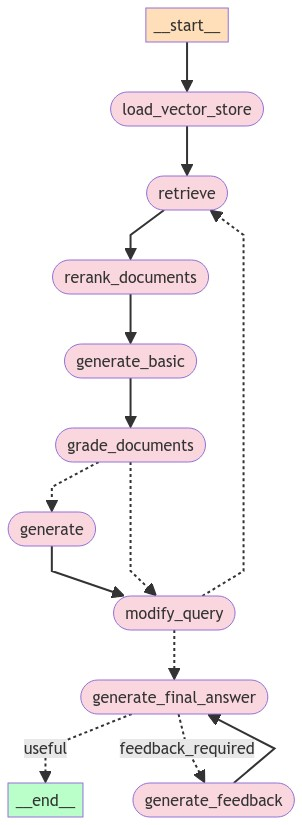

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# """Geef me een nauwkeurige en uitgebreide analyse van de volgende onderdelen in de straf rechtzaak:
# - Het gebruik van versleutelde communicatie systemen (een van deze: pgp-telefoon, encrochat, ennetcom, anom , pgp-safe, sky-ecc)
# - Nauwkeurig overzicht van de belangrijkste bewijs stukken in de rechtzaak
# - Het standpunt van de officier van justitie
# - De argumenten van de verdediging
# - Een nauwkeurige analyse van de argumenten, gebruikt in het oordeel van de rechtbank/rechter


# """

In [ ]:
# """
#   Geef een uitgebreide analyse van de volgende elementen in de rechtszaak:
#   - De belangrijkste bewijsstukken over versleutelde communicatie systemen. Bijvoorbeeld: PGP-telefoons, encrochat, ennetcom, anom , pgp-safe, sky-ecc.
#   - Het standpunt van de officier van justitie of advocaat-generaal over hoe dit bewijs hun zaak ondersteunt.
#   - De argumenten van de verdediging tegen de betrouwbaarheid of wettigheid van dit bewijs.
#   - Een nauwkeurige analyse van de redenering van de rechtbank over de bewijsstukken
#   - Een naukeurige analyse hoe bovenstaande aspecten de einduitspraak van de rechter hebben beïnvloed.

In [ ]:
# Geef een uitgebreide analyse van de volgende elementen in de rechtszaak:
#   - De belangrijkste bewijsstukken over encryptie communicatie systemen.
#   voorbeelde van encryptie systemen: encrochat, sky-ecc, PGP-telefoons, ennetcom, anom, pgp-safe
#   - Het standpunt van de officier van justitie of advocaat-generaal over hoe dit bewijs.
#   - De argumenten van de verdediging tegen dit bewijs.
#   - Een nauwkeurige analyse van de redenering van de rechtbank over de dit bewijs
#   - Een naukeurige analyse hoe de bovenstaande aspecten het oordeel van de rechtbank heeft beinvloed.

In [ ]:
from pprint import pprint

In [ ]:
# # Open the pickle file and load the data from prev batch
# with open('drive/MyDrive/final_results_601.pkl', 'rb') as file:
#     test= pickle.load(file)
# ecli_list = [ecli for ecli in ecli_list if ecli not in test.keys()]
# len(ecli_list)

In [ ]:
unwanted_keys = ['load_vector_store', 'retrieve', 'modify_query', 'generate_feedback', 'rerank_documents']

In [ ]:
def remove_unwanted_keys(results, base_unwanted_keys):
    full_unwanted_keys = {key for key in results.keys() if any(key.startswith(base_key + '_') for base_key in base_unwanted_keys)}

    for key in full_unwanted_keys:
        results.pop(key, None)

    return results

#### JUDGE NEGATIVE VIEW

In [ ]:
results_judge_negativ = {}

In [ ]:
# Run
inputs = {"question": """Geef een gedetailleerd overzicht van de 5 voornaamste redenen van de rechter/rechtbank om bewijs uit versleutelde communicatie (een van deze: encrochat, sky-ecc, pgp-telefoons, ennetcom, anom, pgp-safe) NEGATIEF te beoordelen?
Geef gedetailleerde voorbeelden per reden uit de context waarom de rechter/rechtbank het bewijs NIET als betrouwbaar of rechtmatig heeft beschouwd?
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_judge_negativ[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_judge_negativ = remove_unwanted_keys(results_judge_negativ, unwanted_keys)

print(results_judge_negativ.keys())
with open('/content/drive/MyDrive/results_judge_negativ.pkl', 'wb') as f:
      pickle.dump(results_judge_negativ, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
j

#### Usage CryptoDATA

In [ ]:
results_crypto = {}

In [ ]:
# Run
inputs = {"question": """Welke berichten uit encrochat, sky-ecc, pgp-telefoons, ennetcom, anom, of  pgp-safe hebben gediend als doorslaggevend bewijs door middel van identificatie van de verdachte?
Geef minstens 5 gedetailleerde voorbeelden uit de context over enkel alleen deze berichten.
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_crypto[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_crypto = remove_unwanted_keys(results_crypto, unwanted_keys)

print(results_crypto.keys())
with open('/content/drive/MyDrive/results_crypto.pkl', 'wb') as f:
      pickle.dump(results_crypto, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT

#### Officier van Justitie

In [ ]:
results_Ovj = {}

In [ ]:
# Run
inputs = {"question": """Wat zijn de meest voorkomende standpunten van de officier van justitie (dus GEEN andere actoren)?
Geef gedetailleerde voorbeelden uit de context.
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_Ovj[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_Ovj = remove_unwanted_keys(results_Ovj, unwanted_keys)

print(results_def.keys())
with open('/content/drive/MyDrive/results_Ovj.pkl', 'wb') as f:
      pickle.dump(results_Ovj, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELE

#### De verdediging

In [ ]:
results_def = {}

In [ ]:
# Run
inputs = {"question": """Wat zijn de meest voorkomende standpunten van de verdediging (dus GEEN andere actoren)?
Geef gedetailleerde voorbeelden uit de context.
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_def[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_def = remove_unwanted_keys(results_def, unwanted_keys)

print(results_def.keys())
with open('/content/drive/MyDrive/results_def.pkl', 'wb') as f:
      pickle.dump(results_def, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOC

#### Advocaat-Generaal


In [ ]:
results_AG = {}

In [ ]:
results_AG_freq = {}

In [ ]:
tegeonver bewijs uit versleutelde communicatie

In [ ]:
# Run
inputs = {"question": """Wat zijn de meest voorkomende standpunten van ALLEEN de Advocaat-Generaal (dus GEEN andere actoren)
Geef gedetailleerde voorbeelden per reden uit de context.
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_AG_freq[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_AG_freq = remove_unwanted_keys(results_AG_freq, unwanted_keys)

print(results_AG_freq.keys())
with open('/content/drive/MyDrive/results_AG.pkl', 'wb') as f:
      pickle.dump(results_AG_freq, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
nee
---GRADE: DOCUMENT NOT RELEVANT---


In [ ]:
pprint(results_AG['generate_final_answer_1']['documents'])

[Document(page_content='eerst identificeren we de cruciale kernwoorden in de vraag:\n\n* oordeel van de rechter over het gevonden bewijs\n* gebruik van versleutelde communicatie (encrochat, sky-ecc, pgp-telefoons, ennetcom, anom, pgp-safe)\n* argumenten van de officier van justitie en de advocaat-generaal\n* reactie van de verdediging op deze argumenten\n\nvervolgens identificeren we relevante tekstfragmenten uit de context die direct verband houden met de kernwoorden en de vraag:\n\n* het oordeel van de rechter over het gevonden bewijs wordt niet expliciet genoemd, maar de rechtbank heeft besloten dat de verzoeken van de verdediging worden afgewezen omdat er geen aanleiding is om een ander oordeel te geven.\n* het gebruik van versleutelde communicatie wordt genoemd als een van de onderwerpen die door de verdediging zijn aangevoerd, maar er is geen specifieke discussie over het gebruik van deze communicatie in de zaak.\n* de officier van justitie en de advocaat-generaal hebben argument

In [ ]:
with open('drive/MyDrive/results_AG_OG.pkl', 'wb') as file:
    pickle.dump(results_AG, file)

#### Judge

In [ ]:
results_judge2 = {}

In [ ]:
# Run
inputs = {"question": """Geef aan de hand van belangrijke en specifieke voorbeelden een gedetailleerd overzicht van de 5 voornaamste redenen van de rechter/rechtbank om bewijs uit versleutelde communicatie (een van deze: encrochat, sky-ecc, pgp-telefoons, ennetcom, anom, pgp-safe) te beoordelen als betrouwbaar bewijs?
Geef gedetailleerde voorbeelden per reden uit de context.
  """,
"documents": chunks,
"retrieval_count": 0,
"feedback_count": 0}

node_counts = {}

for output in app.stream(inputs):
    # appends output of every node
    #outputs.append(output)
    for key, value in output.items():
        if key not in node_counts:
              node_counts[key] = 0
        node_counts[key] += 1

          # Create a unique key for each node iteration
        unique_key = f"{key}_{node_counts[key]}"

          # Store the output with its unique key
        results_judge2[unique_key] = value
        pprint(f"Node '{unique_key}' output stored.")
        #pprint(value, indent=2, width=200, depth=None)
    #pprint("\n---\n")

results_judge2 = remove_unwanted_keys(results_judge2, unwanted_keys)

print(results_judge2.keys())
with open('/content/drive/MyDrive/results_judge_23.pkl', 'wb') as f:
      pickle.dump(results_judge2, f)


pprint(value["generation"])

--- LOADING VECTOR STORE---
Loaded FAISS store
"Node 'load_vector_store_1' output stored."
---RETRIEVE---
"Node 'retrieve_1' output stored."
---RE-RANK DOCUMENTS---
"Node 'rerank_documents_1' output stored."
---GENERATE BASIC---
fb: 
"Node 'generate_basic_1' output stored."
---CHECK DOCUMENT RELEVANCE TO QUESTION---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
ja
---GRADE: DOCUMENT RELEVANT---
--

In [ ]:
pprint(results_judge2['generate_final_answer_1']['generation'])

('De rechter heeft het bewijs uit versleutelde communicatie (zoals encrochat, '
 'sky-ecc, pgp-telefoons, ennetcom, anom, pgp-safe) als betrouwbaar beoordeeld '
 'in een specifieke juridische context om verschillende redenen:\n'
 '\n'
 '1) Identificatie van de verdachte als gebruiker van het '
 'communicatieplatform: De rechter heeft vastgesteld dat de identificatie van '
 'de verdachte als gebruiker van specifieke communicatieaccounts, zoals '
 'encrochat en sky-ecc, betrouwbaar en bruikbaar is. Bijvoorbeeld, in de '
 'context wordt vermeld dat de politie de verdachte heeft geïdentificeerd als '
 'de exclusieve gebruiker van het encrochat-account en het sky-id, wat '
 'aantoont dat de communicatie van die accounts aan de verdachte kan worden '
 'toegeschreven.\n'
 '\n'
 '2) Inhoud van de communicatie als indicatie van betrokkenheid bij strafbare '
 'feiten: De rechter heeft geoordeeld dat de communicatie tussen de verdachte '
 'en anderen over criminele activiteiten, zoals het regelen

In [ ]:
for ecli in ecli_list:
  print(f"Processing {ecli}")
  # Run
  inputs = {"question": """
  Wat is het oordeel van de rechter over het gevonden bewijs?
  Hoe heeft versleutelde communicatie (een van deze: encrochat, sky-ecc, pgp-telefoons, ennetcom, anom, pgp-safe) een rol gespeeld in het bewijs?
  Wat is het standpunt en de specifieke argumenten van de officier van justitie ?
  Wat is het standpunt en de specifieke argumenten van de advocaat-generaal?
  Wat is het standpunt en de specifieke argumenten voor de bezwaren van de verdediging?

    """,
  "ecli": ecli,
  "documents": chunks,
  "retrieval_count": 0,
  "feedback_count": 0}

  node_counts = {}
  ecli_outputs = {}

  for output in app.stream(inputs):
      # appends output of every node
      #outputs.append(output)
      for key, value in output.items():
          if key not in node_counts:
                node_counts[key] = 0
          node_counts[key] += 1

            # Create a unique key for each node iteration
          unique_key = f"{key}_{node_counts[key]}"

            # Store the output with its unique key
          ecli_outputs[unique_key] = value
          pprint(f"Node '{unique_key}' output stored.")
          #pprint(value, indent=2, width=200, depth=None)
      #pprint("\n---\n")

  final_results[ecli] = ecli_outputs
  print(f"Processing Number {ecli_list.index(ecli)} out of {len(ecli_list)}")

  with open('/content/drive/MyDrive/final_results103.pkl', 'wb') as f:
        pickle.dump(final_results, f)

  # Final generation
  #pprint(value["generation"])

### Save

In [ ]:
# with open('drive/MyDrive/final_results.pkl', 'wb') as file:
#     pickle.dump(final_results_601, file)

### Preprocess for Evaluation

In [ ]:
import pickle

In [ ]:
# Open the pickle file and load the data
with open('drive/MyDrive/final_results100-bu.pkl', 'rb') as f:
    final_results104 = pickle.load(f)


In [ ]:
# List of base keys for unwanted iterations
unwanted_keys = ['filter_and_load_vector_store', 'retrieve', 'modify_query', 'generate_feedback', 'rerank_documents']

In [ ]:
def remove_unwanted_keys(results, base_unwanted_keys):
    full_unwanted_keys = set()

    # Loop over each ecli outputs to find all iterations of the unwanted keys
    for outputs in results.values():
        for key in outputs.keys():
            # Check if the key starts with any of the base unwanted keys followed by '_'
            if any(key.startswith(base_key + '_') for base_key in base_unwanted_keys):
                full_unwanted_keys.add(key)

    #  remove unwanted keys from results
    for ecli in results:
        for key in full_unwanted_keys:
            results[ecli].pop(key, None)

    return results

In [ ]:
updated_results104 = remove_unwanted_keys(final_results104, unwanted_keys)

In [ ]:
# def extract_page_content(updated_results):
#     for ecli, nodes in updated_results.items():
#         for node, data in nodes.items():
#             if 'documents' in data:
#                 # Replace the list of Document objects with a list of their 'page_content'
#                 updated_results[ecli][node]['documents'] = [doc.page_content for doc in data['documents']]

#     return updated_results


In [ ]:
with open('/content/drive/MyDrive/updated_results104.pkl', 'wb') as file:
    pickle.dump(updated_results104, file)

In [ ]:
with open('/content/drive/MyDrive/updated_results601.pkl', 'rb') as f:
  test = pickle.load(f)